In [1]:
using Pkg
Pkg.activate("../Project.toml")
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/Drift_FeedForward`


In [2]:
using Dates
using Plots
using JLD2
using LsqFit, StatsBase
using QuadGK
using Parameters
using Distributions
using SpecialFunctions
using Random
using SparseArrays
using MultivariateStats


include(joinpath(@__DIR__,"..","src","Parameter_Setting.jl"))
include(joinpath(@__DIR__,"..","src","Dynamics.jl"))
include(joinpath(@__DIR__,"..","src","reversal_learning.jl"))
include(joinpath(@__DIR__,"..","src","Babadi_Formula.jl"))
include(joinpath(@__DIR__,"..","src","Plot.jl"))

cent(X) = X .- mean(X,dims=1)
corr(X,N) = ((X' * X) / N) ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
cov(X,N) = ((X' * X) / N)# ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
palette_J = cgrad(:Blues,6,categorical=true)
palette_h = cgrad(:Oranges,6,categorical=true)
tmp_correlation_ϕ(y,ρ,f) = (1/2π) * quadgk(x -> (ϕ(x - Tf(f)) - f)*(ϕ(ρ*x + sqrt(1-ρ^2)*y-Tf(f))-f) * exp(-(x^2+y^2)/2), -5,5)[1]
correlation_ϕ(ρ,f) =  quadgk(y -> tmp_correlation_ϕ(y,ρ,f), -5,5)[1]/(f*(1-f))
angle_correct(θ) = θ > 0 ? θ : θ + 2π

angle_correct (generic function with 1 method)

In [3]:
#23s
p.dt = 0.1
p.t_end = 11.
p.r = 0.5
p.γW = 10^(-1.)
p.λ = 1.;
ϕ(x) = x > 0 ? 1 : 0
p.f = 0.1
p.model = :dense_normal

:dense_normal

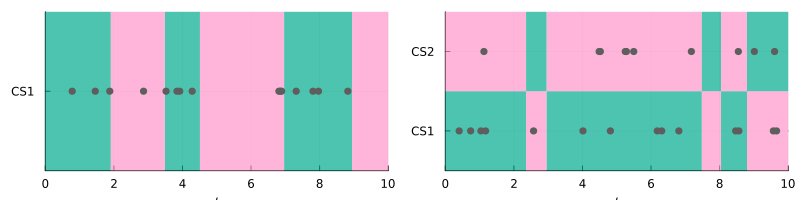

In [4]:



colors = ["#5E5E5E","#5E5E5E"]
shapes = [:circle,:circle]

Plist = [1,2]


plots = Array{Any}(undef,length(Plist))
X_event = 1

for i_P in 1:length(Plist)
    p.P = Plist[i_P] #choose P=1 or P=2
    S = zeros(p.Ns,p.P)
    L = zeros(p.P)
    L[1] = +1;
    if p.P == 1
        Random.seed!(0123) #P=1
    elseif p.P == 2
        Random.seed!(0) #P=2
        L[2] = -1
    end

    t_event_list,h̃,J̃, X,gL = trajectory(p,1/p.γW,1,S,L,ϕ)

    i_event = [[] for i in 1:p.P+2]
    t_event = [[] for i in 1:p.P+2]
    X_event = [[] for i in 1:p.P+2]
    for i in 1:length(t_event_list)
        push!(i_event[t_event_list[i][2]+1], i)
        push!(t_event[t_event_list[i][2]+1], t_event_list[i][1])
        push!(X_event[t_event_list[i][2]+1], X[i])
    end
    t_all = [t_event_list[i][1] for i in 1:length(t_event_list)];

    plot()
    color1 = "#00AB8E"; color2 = "#FF95CA"; alpha = 0.7
    if p.P ∈ [1,2]
        plot_alternating_regions!(p,X[1],t_event[p.P+2],fillcolor = color1,fillrange = 1.5,alpha=alpha)
        plot_alternating_regions!(p,1-X[1],t_event[p.P+2],fillcolor = color2,fillrange = 1.5,alpha=alpha)
    end
    if p.P == 2
        plot_alternating_regions!(p,X[1],t_event[p.P+2],fillcolor = color2,fillrange = (1.5,2.5),alpha=alpha)
        plot_alternating_regions!(p,1-X[1],t_event[p.P+2],fillcolor = color1,fillrange = (1.5,2.5),alpha=alpha)
    end
    #plot_alternating_regions!(p,X[1],t_event[p.P+2])
    for i in 1:p.P
        scatter!(t_event[i+1],i*ones(length(t_event[i+1])),color = colors[i],markerstrokewidth=0,legend=false,markershape = [shapes[X_event[i+1][j] ⊻ (L[i] == +1) + 1] for j in 1:length(X_event[i+1])])
    end
    #plot!(t_all, X)
    plot!(xlabel = "\$t\$")
    plots[i_P] = plot!(
        ylim = (0.5,p.P+0.5),
        xlim = (0,10),
        yticks = (1:p.P, ["CS$(i)" for i in 1:p.P]),
    )
end
plot(plots...,size = (800,200))
savefig("../figure/reversal_learning_trajectory.pdf")
plot!()

In [14]:
include("../src/Plot.jl")

plot_normality_g (generic function with 1 method)

In [10]:
size(PI_bootstrap)

(2, 9, 3, 1, 1)

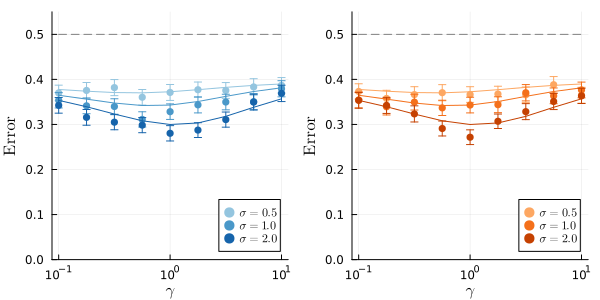

In [19]:
filename = "reversal_learning_1odor_2025-07-29T23:42:56.223"
ρLmn = [1];ρSmn = [1]
PI_bootstrap, PI_analytical,σlist,Nclist,λlist,γlist = file2PI_infs(filename,ρLmn,ρSmn)
para_list = σlist; para_name = "\\sigma"; d_palette = 2
PIplot(PI_bootstrap[:,:,1:3,1,1], PI_analytical[:,:,1:3,1,1], para_list[1:3], para_name,d_palette,γlist)
savefig("../figure/reversal_learning_1odor.pdf")
plot!()

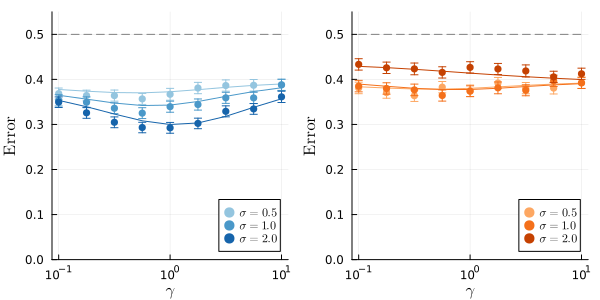

In [15]:
filename = "reversal_learning_2odor_2025-07-30T03:00:29.492"
ρLmn = [1 -1; -1 1];ρSmn = [1 0; 0 1]
PI_bootstrap, PI_analytical,σlist,Nclist,λlist,γlist = file2PI_infs(filename,ρLmn,ρSmn)
para_list = σlist; para_name = "\\sigma"; d_palette = 2
PIplot(PI_bootstrap[:,:,1:3,1,1], PI_analytical[:,:,1:3,1,1], para_list[1:3], para_name,d_palette,γlist)
savefig("../figure/reversal_learning_2odor.pdf")  
plot!()

### Fig. S5

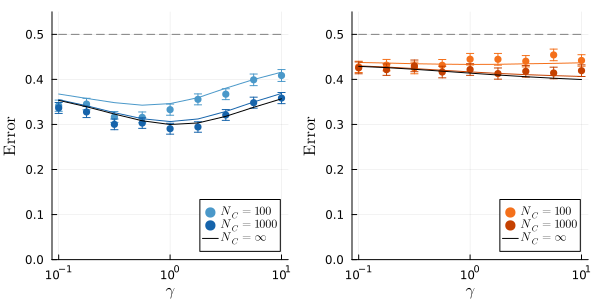

In [17]:
#10s
filename = "reversal_learning_2odor_Nc_2025-07-30T04:09:11.196"
ρLmn = [1 -1; -1 1];ρSmn = [1 0; 0 1]
PI_bootstrap, PI_analytical,σlist,Nclist,λlist,γlist = file2PI(filename,ρLmn,ρSmn)
PI_analytical_inf = file2PI_inf(filename,ρLmn,ρSmn)
para_list = Nclist; para_name = "N_{C}"; d_palette = 3
PIplot(PI_bootstrap[:,:,1,:,1], PI_analytical[:,:,1,:,1], para_list, para_name,d_palette,γlist;PI_analytical_inf)
savefig("../figure/reversal_learning_2odor_Nc.pdf")  
plot!()

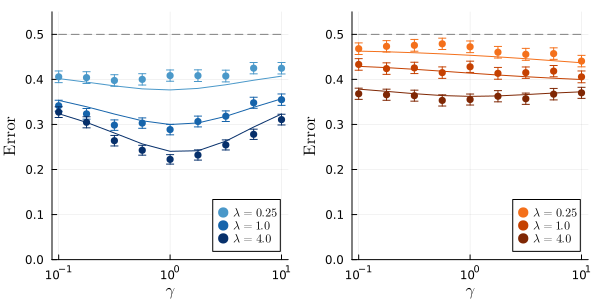

In [18]:
filename = "reversal_learning_2odor_λ_2025-07-30T09:15:23.585"
ρLmn = [1 -1; -1 1];ρSmn = [1 0; 0 1]
PI_bootstrap, PI_analytical,σlist,Nclist,λlist,γlist = file2PI_infs(filename,ρLmn,ρSmn)
para_list = λlist; para_name = "\\lambda"; d_palette = 3
PIplot(PI_bootstrap[:,:,1,1,:], PI_analytical[:,:,1,1,:], para_list, para_name,d_palette,γlist)
savefig("../figure/reversal_learning_2odor_λ.pdf")  
plot!()

### Fig. S4

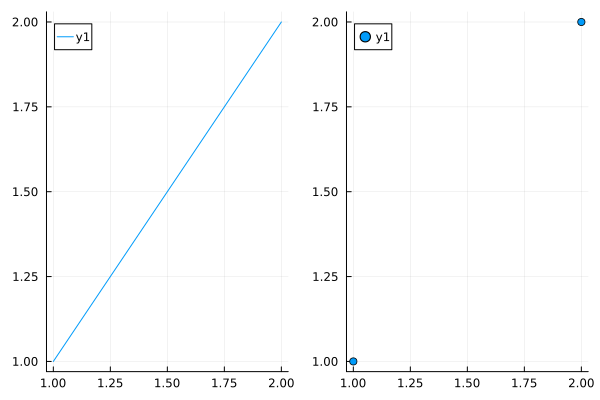

In [21]:
plot(plot([1,2],[1,2]),scatter([1,2],[1,2]),layout = (1,2))

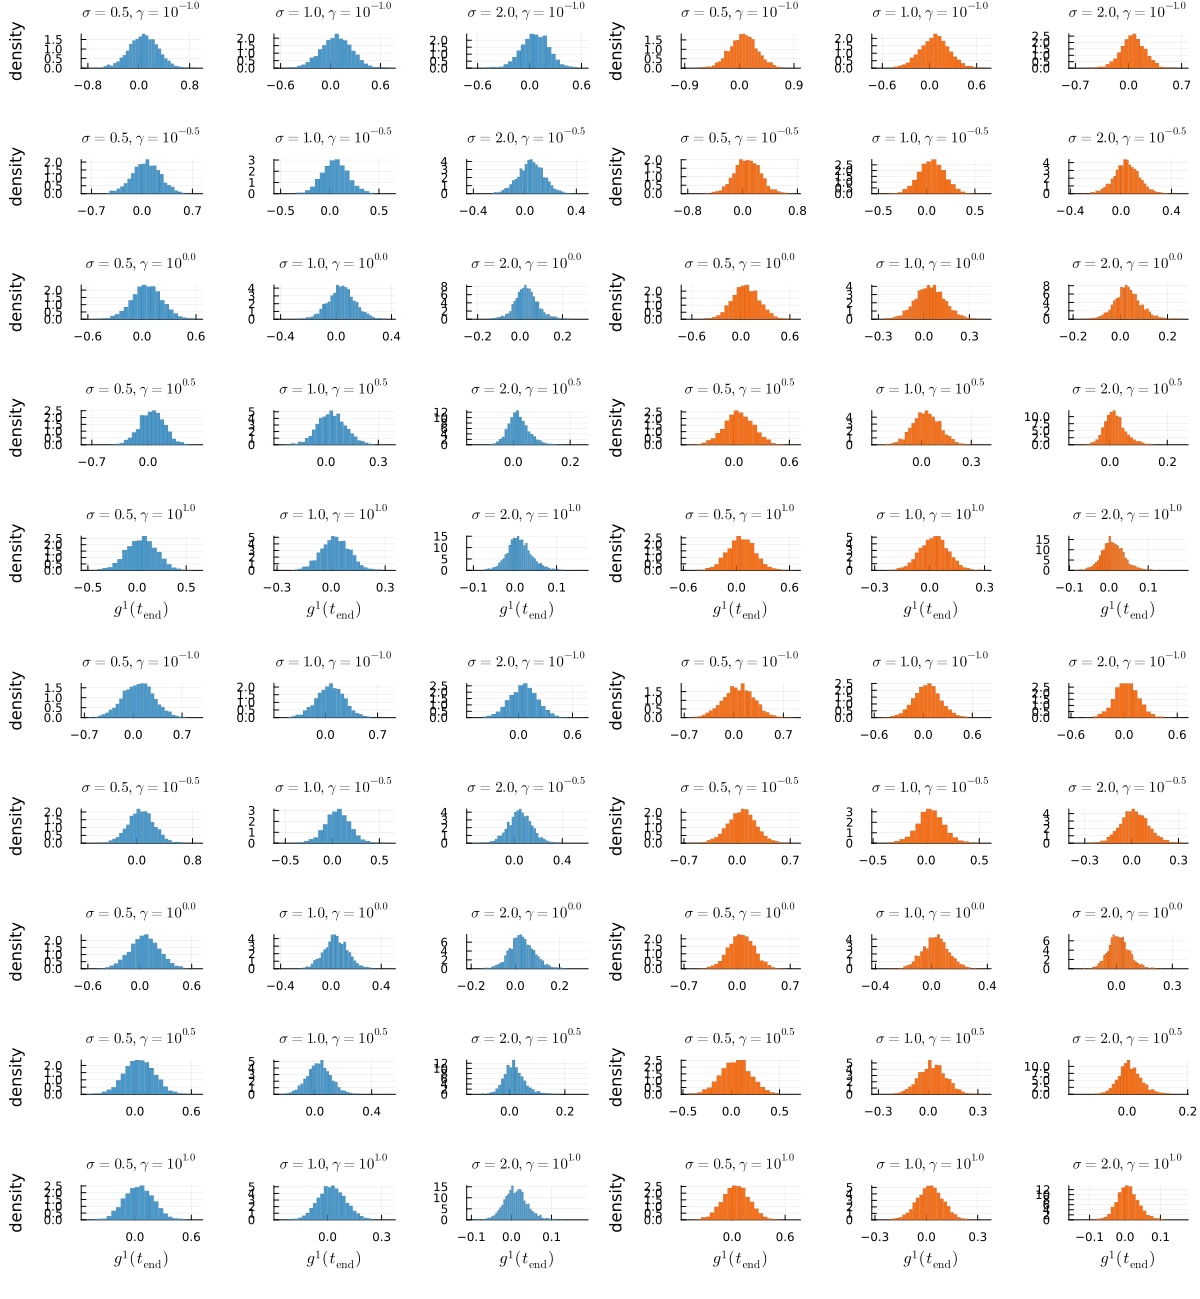

In [26]:
filename = "reversal_learning_1odor_2025-07-29T23:42:56.223"
p_array,γ_sublist,σlist = plot_normality_g(filename)
p1 = plot(p_array[1,:,:]...,layout = (length(γ_sublist),length(σlist)),size = (600,600),legend=false)
p2 = plot(p_array[2,:,:]...,layout = (length(γ_sublist),length(σlist)),size = (600,600),legend=false)
#switch plot order of J and h
p_1odor = plot(p2,p1,size = (1200,600),bottommargin=5Plots.mm,leftmargin = 5Plots.mm)
#savefig("../figure/normality_g_P1.pdf")

filename = "reversal_learning_2odor_2025-07-30T03:00:29.492"
p_array,γ_sublist,σlist = plot_normality_g(filename)
p1 = plot(p_array[1,:,:]...,layout = (length(γ_sublist),length(σlist)),size = (600,600),legend=false)
p2 = plot(p_array[2,:,:]...,layout = (length(γ_sublist),length(σlist)),size = (600,600),legend=false)
#switch plot order of J and h
p_2odor = plot(p2,p1,size = (1200,600),bottommargin=5Plots.mm,leftmargin = 5Plots.mm)
#savefig("../figure/normality_g_P2.pdf")
plot(p_1odor,p_2odor,layout = (2,1),size = (1200,1300))
savefig("../figure/normality_g.pdf")
plot!()